In [4]:
import pandas as pd
import numpy as np
import scipy
import nimfa
from scipy.sparse import csc_matrix, csr_matrix, lil_matrix
from scipy.sparse.linalg import *

data_frame = pd.read_csv('stocks_final.csv', delimiter=';')
np.random.seed(42)

In [5]:
# датасет с акциями

In [6]:
# косинусная и евклидова метрика качества 

def cosine_distance(x, y):
    return 1.0 - np.dot(x, y.T)/np.sqrt(np.multiply.outer((x*x).sum(axis=-1), (y*y).sum(axis=-1)))

def euclidean_distance(x, y):
    return np.sqrt((np.add.outer((x*x).sum(axis=-1), (y*y).sum(axis=-1)) - 2*np.dot(x, y.T)))

#creating function to get recommendations
def recommender(investors, df_predict, user, number_recomm):
    user_predicted = df_predict.loc[user, :].sort_values(ascending = False)

    # already_rated
    rated = pd.DataFrame()
    rated['name'] = investors.columns
    d = investors.loc[user, :].to_list()
    rated['rating'] = d
    already_rated = rated.dropna()
    
    # unrated
    unrated = list(investors.loc[1, pd.isnull(investors.loc[user, :])].index)
    recommendations = df_predict.loc[user][unrated]
    recommendations = pd.DataFrame(recommendations.sort_values(ascending = False).index[:number_recomm])
    
    return recommendations, already_rated

In [7]:
columns_to_drop = [
    'Description', 
    'Currency', 
    'Country', 
    'Address', 
    'FiscalYearEnd', 
    'LatestQuarter', 
    'FullTimeEmployees'
]

data_frame.drop(columns_to_drop, axis=1, inplace=True)

#data_frame.info()

df_new = data_frame.copy()
df_new['MarketCapitalization'] =  pd.to_numeric(df_new['MarketCapitalization'], errors='coerce')
df_new['EBITDA'] =  pd.to_numeric(df_new['EBITDA'], errors='coerce')
df_new['PERatio'] =  pd.to_numeric(df_new['PERatio'], errors='coerce')
df_new['DividendYield'] =  pd.to_numeric(df_new['DividendYield'], errors='coerce')
df_new['Beta'] =  pd.to_numeric(df_new['Beta'], errors='coerce')
df_new['ReturnOnAssetsTTM'] =  pd.to_numeric(df_new['ReturnOnAssetsTTM'], errors='coerce')
df_new['ReturnOnEquityTTM'] =  pd.to_numeric(df_new['ReturnOnEquityTTM'], errors='coerce')
df_new['52WeekHigh'] =  pd.to_numeric(df_new['52WeekHigh'], errors='coerce')
df_new['52WeekLow'] =  pd.to_numeric(df_new['52WeekLow'], errors='coerce')
df_new['AnalystTargetPrice'] =  pd.to_numeric(df_new['AnalystTargetPrice'], errors='coerce')
df_new['200DayMovingAverage'] =  pd.to_numeric(df_new['200DayMovingAverage'], errors='coerce')
df_new['Volatility'] = (df_new['52WeekHigh'] - df_new['52WeekLow']) / df_new['52WeekLow']
#df_new = df_new.dropna() #если эту строку включить в  код, то будет 2305 бумаг в матрице
#print ("Old shape:", data_frame.shape)
#print ("New shape:", df_new.shape)
#df_new.info()

In [8]:
stocks = list(df_new['Symbol'])
#investors = pd.DataFrame(columns = stocks)
investors = pd.read_csv('portfolio_fix_all_20.csv', delimiter=',', )

columns_to_drop = [
    'id_investor', 
]

investors.drop(columns_to_drop, axis=1, inplace=True)

In [9]:
count_zero = investors.fillna(0).values
shape_matrix = count_zero.shape[0] * count_zero.shape[1]
zeros = len(np.argwhere(count_zero == 0))
print(f'нулей {zeros / shape_matrix:.4%}, не нулей {1 - zeros / shape_matrix:.4%}')

нулей 99.8396%, не нулей 0.1604%


In [10]:
#test portfolio
#portfolio = ['AAPL', 'NVDA', 'MSFT', 'LOGI', 'XRX'] # технологический сектор в чистом виде
#portfolio = ['GOLD', 'AMD', 'ZIONO', 'GS', 'JPM'] # уклон в финансовый сектор (3 шт) + добыча (1) и технологии (1)
#portfolio = ['AAL', 'ADT', 'CAT', 'GASS', 'WSO'] # промышленность
#portfolio = ['T', 'VZ', 'AMZN', 'INTC', 'AAPL'] # топ EBITDA
#portfolio = ['GOOD', 'CWK', 'PTAC', 'VSAT', 'ATNI'] # топ PERatio
results = {}
portfolio = [['AAPL', 'NVDA', 'MSFT', 'LOGI', 'XRX'],
             ['GOLD', 'AMD', 'ZIONO', 'GS', 'JPM'],
             ['AAL', 'ADT', 'CAT', 'GASS', 'WSO'],
             ['T', 'VZ', 'AMZN', 'INTC', 'AAPL'],
             ['GOOD', 'CWK', 'PTAC', 'VSAT', 'ATNI'],
            ]
rates = [5, 5, 5, 5, 5]
id_investors = investors.shape[0]
df_new.rename(index=df_new['Symbol'], inplace=True)
previous_portfolio = portfolio[0]

In [86]:
for p in range(len(portfolio)):
    for r, s in enumerate(previous_portfolio):
        investors.loc[id_investors, s] = 0
    for r, s in enumerate(portfolio[p]):
        investors.loc[id_investors, s] = rates[r]
    previous_portfolio = portfolio[p]
    
    results[p] = [portfolio[p]]
    #filling nans with 0
    investors_new = investors.fillna(0)
    investors_matrix = investors_new.values # csr_matrix(investors_new.values)

    # svd-decomposition
    # k надо подобрать обучением модели
    U, sigma, Vt = svds(investors_matrix, k = 12)
    sigma = np.diag(sigma)

    #creating predictions
    predicted_ratings = np.dot(np.dot(U, sigma), Vt)
    predicted_df = pd.DataFrame(predicted_ratings, columns=investors.columns)
    predicted_df.index = predicted_df.index + 1
    #predicted_df

    # getting recommendations
    user = id_investors
    number_recomm = 5

    recommend, rated = recommender(investors, predicted_df, user, number_recomm)
    print(f'Top {number_recomm} Recommendations')
    print(recommend)
    print('-----------------')
    print('Best rated')
    rated_sort = rated.sort_values(ascending = False, by = 'rating')[:5]
    print(rated_sort.loc[:,['name','rating']])

    results[p].append(recommend[0].to_list())
    
    # фичи рекомендаций 
    recommend_items = recommend[0].to_list()
    rows_recommend = df_new.loc[recommend_items, :]
    rows_recommend.fillna(0, inplace=True)
    rows_recommend.drop('Symbol', axis=1, inplace=True)

    # фичи уже выбранных ранее 
    rated_items = rated_sort['name'].to_list()
    rows_rated = df_new.loc[rated_items, :]
    rows_rated.fillna(0, inplace=True)
    rows_rated.drop('Symbol', axis=1, inplace=True)

    # выбираем только числовые поля рекомендаций 

    df_numerics_only = rows_recommend.select_dtypes(include=np.number)
    colnames_numerics_only = rows_recommend.select_dtypes(include=np.number).columns.tolist()
    rows_recommend_number = rows_recommend.loc[:, colnames_numerics_only]
    #rows_recommend_number

    # выбираем только числовые поля уже ранее выбранных

    df_numerics_only = rows_rated.select_dtypes(include=np.number)
    colnames_numerics_only = rows_rated.select_dtypes(include=np.number).columns.tolist()
    rows_rated_number = rows_rated.loc[:, colnames_numerics_only]
    #rows_rated_number

    # расчет качества рекомендации (по попаданию в доверительный интервал)
    try:
        mean_vals = rows_rated_number.mean()
        var_vals = rows_rated_number.std()
        bound_right = mean_vals + var_vals
        bound_left = mean_vals - var_vals

        count = 0
        left = []
        right = []
        for index, row in rows_recommend_number.iterrows():
            left.append(row >= bound_left)
            right.append(row >= bound_right)
        result = left and right
        for el in result:
            count += el.value_counts()[1]
        print('Качество рекомендации ДИ: ', count/rows_rated_number.shape[1]/number_recomm*100, '%')
        results[p].append(count/rows_rated_number.shape[1]/number_recomm)
    except:
        mean_vals = rows_rated_number.mean()
        var_vals = rows_rated_number.std()
        bound_right = mean_vals + 0 * var_vals
        bound_left = mean_vals - 0 * var_vals

        count = 0
        left = []
        right = []
        for index, row in rows_recommend_number.iterrows():
            left.append(row >= bound_left)
            right.append(row >= bound_right)
        result = left and right
        for el in result:
            count += el.value_counts()[1]
        print('Качество рекомендации ДИ (exc): ', count/rows_rated_number.shape[1]/number_recomm*100, '%')
        results[p].append(count/rows_rated_number.shape[1]/number_recomm)
    # качество по косинусной метрике

    rows_rated_number_matrix = rows_rated_number.values
    rows_recommend_number_matrix = rows_recommend_number.values
    dist = cosine_distance(rows_rated_number_matrix, rows_recommend_number_matrix)
    err = np.min(dist, axis=1)
    err_rel = np.sum(err)/(number_recomm)
    results[p].append(1 - err_rel)
    print('Качество рекомендации COS: ', (1 - err_rel)*100, '%')

TypeError: 'Series' objects are mutable, thus they cannot be hashed

In [10]:
results

{0: [['AAPL', 'NVDA', 'MSFT', 'LOGI', 'XRX'],
  ['WEYS', 'VRA', 'FL', 'TTM', 'GM'],
  0.08717948717948718,
  0.7321431059371037],
 1: [['GOLD', 'AMD', 'ZIONO', 'GS', 'JPM'],
  ['WEYS', 'VRA', 'FL', 'TTM', 'GM'],
  0.13333333333333333,
  0.7910268477235449],
 2: [['AAL', 'ADT', 'CAT', 'GASS', 'WSO'],
  ['WEYS', 'VRA', 'FL', 'TTM', 'GM'],
  0.30256410256410254,
  0.9257599080096331],
 3: [['T', 'VZ', 'AMZN', 'INTC', 'AAPL'],
  ['WEYS', 'VRA', 'FL', 'TTM', 'GM'],
  0.11794871794871795,
  0.8226322904002294],
 4: [['GOOD', 'CWK', 'PTAC', 'VSAT', 'ATNI'],
  ['WEYS', 'VRA', 'FL', 'TTM', 'GM'],
  0.22051282051282053,
  0.834965646250856]}

In [8]:
rows_rated

,AssetType,Name,Exchange,Sector,Industry,MarketCapitalization,EBITDA,PERatio,PEGRatio,BookValue,...,PercentInsiders,PercentInstitutions,ForwardAnnualDividendRate,ForwardAnnualDividendYield,PayoutRatio,DividendDate,ExDividendDate,LastSplitFactor,LastSplitDate,Volatility
ATNI,Common Stock,"ATN International, Inc",NASDAQ,Communication Services,Telecom Services,8.074848e+08,119625000.0,12458.000,15.47,42.555,...,30.809,67.088,0.68,0.0134,68.0,2020-10-09,2020-09-29,5:2,2006-04-03,1.151851
VSAT,Common Stock,"Viasat, Inc",NASDAQ,Technology,Communication Equipment,2.475081e+09,345572000.0,5397.000,94.32,33.762,...,3.899,88.317,0.00,0.0000,0.0,None,None,2:1,2000-09-01,1.965339
CWK,Common Stock,Cushman & Wakefield plc,NYSE,Real Estate,Real Estate Services,3.297854e+09,317500000.0,10090.000,None,4.716,...,21.951,72.518,0.00,0.0000,0.0,None,None,None,None,2.040205
PTAC,Common Stock,PropTech Acquisition Corporation,NASDAQ,Financial Services,Shell Companies,2.182125e+08,0.0,6909.091,None,None,...,0.000,102.388,0.00,0.0000,0.0,None,None,None,None,0.202186
GOOD,Common Stock,Gladstone Commercial Corporation,NASDAQ,Real Estate,REITDiversified,6.369327e+08,90498000.0,21940.000,-62.67,5.794,...,1.661,59.056,1.50,0.0834,0.0,2020-12-31,2020-11-19,None,None,2.039526


In [9]:
rows_recommend

,AssetType,Name,Exchange,Sector,Industry,MarketCapitalization,EBITDA,PERatio,PEGRatio,BookValue,...,PercentInsiders,PercentInstitutions,ForwardAnnualDividendRate,ForwardAnnualDividendYield,PayoutRatio,DividendDate,ExDividendDate,LastSplitFactor,LastSplitDate,Volatility
GRFS,Common Stock,"Grifols, S.A",NASDAQ,Healthcare,Drug ManufacturersGeneral,1.839628e+10,0.000000e+00,16.1644,1.2932,3.5575,...,0.000,44.693,0.42,0.0222,0.3360,2020-11-09,2020-10-30,2:1,2016-01-04,0.920149
SONO,Common Stock,"Sonos, Inc",NASDAQ,Technology,Consumer Electronics,1.879434e+09,1.065500e+07,196.0976,None,2.368,...,1.231,61.374,0.00,0.0000,0.0000,None,None,None,None,1.709726
NVS,Common Stock,Novartis AG,NYSE,Healthcare,Drug ManufacturersGeneral,1.963814e+11,1.797500e+10,27.8641,2.68,23.954,...,0.003,10.166,3.09,0.0357,0.5360,2020-03-12,2020-03-03,1116:1000,2019-04-09,0.420784
SNY,Common Stock,Sanofi,NASDAQ,Healthcare,Drug ManufacturersGeneral,1.263948e+11,0.000000e+00,9.7844,3.3074,26.249,...,0.001,7.011,1.70,0.0333,0.4969,2020-05-26,2020-04-30,5:1,2013-09-30,0.461988
MRK,Common Stock,"Merck & Co., Inc",NYSE,Healthcare,Drug ManufacturersGeneral,2.020862e+11,1.900600e+10,17.6291,1.219,11.537,...,0.077,75.507,2.44,0.0301,0.4229,2020-10-07,2020-09-14,2:1,1999-02-17,0.419770


# PMF

In [6]:
results = {}
portfolio = [#['AAPL', 'NVDA', 'MSFT', 'LOGI', 'XRX'],
             #['GOLD', 'AMD', 'ZIONO', 'GS', 'JPM'],
             #['AAL', 'ADT', 'CAT', 'GASS', 'WSO'],
             ['T', 'VZ', 'AMZN', 'INTC', 'AAPL'],
             ['GOOD', 'CWK', 'PTAC', 'VSAT', 'ATNI'],
            ]
rates = [5, 5, 5, 5, 5]
id_investors = investors.shape[0]
df_new.rename(index=df_new['Symbol'], inplace=True)
previous_portfolio = portfolio[0]
for p in range(len(portfolio)):
    for r, s in enumerate(previous_portfolio):
        investors.loc[id_investors, s] = 0
    for r, s in enumerate(portfolio[p]):
        investors.loc[id_investors, s] = rates[r]
    previous_portfolio = portfolio[p]
    
    results[p] = [portfolio[p]]
    #filling nans with 0
    investors_new = investors.fillna(0)
    investors_matrix = csr_matrix(investors_new.values) # investors_new.values #

    # pmf-разложение матрицы
    # nimfa
    pmf = nimfa.Pmf(investors_matrix, seed="random_vcol", rank=10, max_iter=12, rel_error=1e-5)
    pmf_fit = pmf()

    #creating predictions

    predicted_ratings = np.matmul(pmf.W, pmf.H)
    predicted_df = pd.DataFrame(predicted_ratings, columns=investors.columns)
    predicted_df.index = predicted_df.index + 1
    #predicted_df

    # getting recommendations

    user = id_investors
    number_recomm = 5

    recommend, rated = recommender(investors, predicted_df, user, number_recomm)
    print(f'Top {number_recomm} Recommendations')
    print(recommend)
    print('-----------------')
    print('Best rated')
    rated_sort = rated.sort_values(ascending = False, by = 'rating')[:5]
    print(rated_sort.loc[:,['name','rating']])
    
    results[p].append(recommend[0].to_list())
    
    # фичи рекомендаций 

    recommend_items = recommend[0].to_list()
    rows_recommend = df_new.loc[recommend_items, :]
    rows_recommend.fillna(0, inplace=True)
    rows_recommend.drop('Symbol', axis=1, inplace=True)

    # фичи уже выбранных ранее 

    rated_items = rated_sort['name'].to_list()
    rows_rated = df_new.loc[rated_items, :]
    rows_rated.fillna(0, inplace=True)
    rows_rated.drop('Symbol', axis=1, inplace=True)

    # выбираем только числовые поля рекомендаций 

    df_numerics_only = rows_recommend.select_dtypes(include=np.number)
    colnames_numerics_only = rows_recommend.select_dtypes(include=np.number).columns.tolist()
    rows_recommend_number = rows_recommend.loc[:, colnames_numerics_only]
    #rows_recommend_number

    # выбираем только числовые поля уже ранее выбранных

    df_numerics_only = rows_rated.select_dtypes(include=np.number)
    colnames_numerics_only = rows_rated.select_dtypes(include=np.number).columns.tolist()
    rows_rated_number = rows_rated.loc[:, colnames_numerics_only]
    #rows_rated_number

# расчет качества рекомендации (по попаданию в доверительный интервал)
    try:
        mean_vals = rows_rated_number.mean()
        var_vals = rows_rated_number.std()
        bound_right = mean_vals + var_vals
        bound_left = mean_vals - var_vals

        count = 0
        left = []
        right = []
        for index, row in rows_recommend_number.iterrows():
            left.append(row >= bound_left)
            right.append(row >= bound_right)
        result = left and right
        for el in result:
            count += el.value_counts()[1]
        print('Качество рекомендации ДИ: ', count/rows_rated_number.shape[1]/number_recomm*100, '%')
        results[p].append(count/rows_rated_number.shape[1]/number_recomm)
    except:
        mean_vals = rows_rated_number.mean()
        var_vals = rows_rated_number.std()
        bound_right = mean_vals + 0 * var_vals
        bound_left = mean_vals - 0 * var_vals

        count = 0
        left = []
        right = []
        for index, row in rows_recommend_number.iterrows():
            left.append(row >= bound_left)
            right.append(row >= bound_right)
        result = left and right
        for el in result:
            count += el.value_counts()[1]
        print('Качество рекомендации ДИ (exc): ', count/rows_rated_number.shape[1]/number_recomm*100, '%')
        results[p].append(count/rows_rated_number.shape[1]/number_recomm)

    # качество по косинусной метрике

    rows_rated_number_matrix = rows_rated_number.values
    rows_recommend_number_matrix = rows_recommend_number.values
    dist = cosine_distance(rows_rated_number_matrix, rows_recommend_number_matrix)
    err = np.min(dist, axis=1)
    err_rel = np.sum(err)/(number_recomm)
    results[p].append(1 - err_rel)
    print('Качество рекомендации: ', (1-err_rel)*100, '%')

Top 5 Recommendations
       0
0  HVT-A
1   GPRO
2     LL
3   SONO
4    LPL
-----------------
Best rated
      name  rating
16    AAPL     5.0
343   AMZN     5.0
2935  INTC     5.0
5356     T     5.0
5924    VZ     5.0
Качество рекомендации ДИ:  12.820512820512823 %
Качество рекомендации:  94.37808301701396 %
Top 5 Recommendations
      0
0   JNJ
1   LLY
2  VIOT
3  AMKR
4    KO
-----------------
Best rated
      name  rating
534   ATNI     5.0
1544   CWK     5.0
2461  GOOD     5.0
4547  PTAC     5.0
5898  VSAT     5.0
Качество рекомендации ДИ:  40.51282051282051 %
Качество рекомендации:  96.96576397109142 %


In [332]:
res = {'res_20k_svd':{0: [['AAPL', 'NVDA', 'MSFT', 'LOGI', 'XRX'],
  ['SONO', 'BMY', 'ABBV', 'GRFS', 'SNY'],
  0.1641025641025641,
  0.9732343615936496],
 1: [['GOLD', 'AMD', 'ZIONO', 'GS', 'JPM'],
  ['SONO', 'BMY', 'ABBV', 'GRFS', 'SNY'],
  0.13333333333333333,
  0.8960515450509341],
 2: [['AAL', 'ADT', 'CAT', 'GASS', 'WSO'],
  ['SONO', 'BMY', 'ABBV', 'GRFS', 'SNY'],
  0.21538461538461537,
  0.9094310823885067],
 3: [['T', 'VZ', 'AMZN', 'INTC', 'AAPL'],
  ['SONO', 'BMY', 'ABBV', 'GRFS', 'SNY'],
  0.18461538461538463,
  0.9843361392108322],
 4: [['GOOD', 'CWK', 'PTAC', 'VSAT', 'ATNI'],
  ['SONO', 'BMY', 'ABBV', 'GRFS', 'SNY'],
  0.3435897435897436,
  0.9584695880751779]},
'res_5k_svd':{0: [['AAPL', 'NVDA', 'MSFT', 'LOGI', 'XRX'],
  ['GRFS', 'SONO', 'NVS', 'SNY', 'MRK'],
  0.15897435897435896,
  0.972687190141225],
 1: [['GOLD', 'AMD', 'ZIONO', 'GS', 'JPM'],
  ['GRFS', 'SONO', 'NVS', 'SNY', 'MRK'],
  0.11794871794871795,
  0.8962959194526988],
 2: [['AAL', 'ADT', 'CAT', 'GASS', 'WSO'],
  ['GRFS', 'SONO', 'NVS', 'SNY', 'MRK'],
  0.21025641025641026,
  0.9088117439637865],
 3: [['T', 'VZ', 'AMZN', 'INTC', 'AAPL'],
  ['GRFS', 'SONO', 'NVS', 'SNY', 'MRK'],
  0.18974358974358974,
  0.9835014191367919],
 4: [['GOOD', 'CWK', 'PTAC', 'VSAT', 'ATNI'],
  ['GRFS', 'SONO', 'NVS', 'SNY', 'MRK'],
  0.3435897435897436,
  0.9583914709662755]},
'res_20k_pmf':{0: [['AAPL', 'NVDA', 'MSFT', 'LOGI', 'XRX'],
  ['VIOT', 'HVT-A', 'VUZI', 'HEAR', 'LPL'],
  0.09743589743589744,
  0.9408557375432826],
 1: [['GOLD', 'AMD', 'ZIONO', 'GS', 'JPM'],
  ['LLY', 'AZN', 'GRFS', 'PFE', 'FND'],
  0.11794871794871795,
  0.8442291768977339],
 2: [['AAL', 'ADT', 'CAT', 'GASS', 'WSO'],
  ['GPRO', 'LPL', 'FCAU', 'VRA', 'HMC'],
  0.10769230769230768,
  0.9560875526519103],
 3: [['T', 'VZ', 'AMZN', 'INTC', 'AAPL'],
  ['HVT-A', 'GPRO', 'LL', 'SONO', 'LPL'],
  0.12820512820512822,
  0.9437808301701396],
 4: [['GOOD', 'CWK', 'PTAC', 'VSAT', 'ATNI'],
  ['JNJ', 'LLY', 'VIOT', 'AMKR', 'KO'],
  0.40512820512820513,
  0.9696576397109142]},
'res_5k_pmf':{0: [['AAPL', 'NVDA', 'MSFT', 'LOGI', 'XRX'],
  ['LOW', 'SONO', 'SNE', 'HBB', 'HVT-A'],
  0.09230769230769231,
  0.910932178533372],
 1: [['GOLD', 'AMD', 'ZIONO', 'GS', 'JPM'],
  ['SONO', 'HBB', 'HEAR', 'BMY', 'LLY'],
  0.16923076923076924,
  0.9349290455865137],
 2: [['AAL', 'ADT', 'CAT', 'GASS', 'WSO'],
  ['KOSS', 'SNE', 'SONO', 'NVEC', 'NPTN'],
  0.10769230769230768,
  0.9391438709289451],
 3: [['T', 'VZ', 'AMZN', 'INTC', 'AAPL'],
  ['HEAR', 'IRBT', 'LLY', 'SONO', 'COKE'],
  0.15897435897435896,
  0.9885163464554905],
 4: [['GOOD', 'CWK', 'PTAC', 'VSAT', 'ATNI'],
  ['GPRO', 'SONO', 'HEAR', 'IRBT', 'LPL'],
  0.2512820512820513,
  0.9401054047889706]}
}

In [333]:
def ruslan_quality(rated, recommendations):
    
    def calc_sector(rated_stocks_params, recommended_stocks_params):
        rated_stocks_stats = rated_stocks_params.groupby(['Sector']).size().reset_index(name='Count')
        recommended_stocks_stats = recommended_stocks_params.groupby(['Sector']).size().reset_index(name='Count')
        # а)
        if rated_stocks_stats.shape[0] == 1:
            print(311, end=' ')
            cur_sector = rated_stocks_stats['Sector'][0]
            print(cur_sector, end=' ')
            recommended_stocks_count = recommended_stocks_stats.loc[recommended_stocks_stats['Sector'] == cur_sector]
            print(recommended_stocks_count['Count'][0], end=' ')
            if recommended_stocks_count['Count'].empty:
                return 0
            
            count = recommended_stocks_count['Count'][0]
            print(count)
            if count in [2, 3]:
                return 1
            elif count in [1, 4]:
                return 0.5
            else:
                return 0
        # b)
        else:
            print(322)
            max_same_sector_count = recommended_stocks_stats['Count'].max()
            if max_same_sector_count <=2:
                return 1
            elif max_same_sector_count == 3:
                return 0.5
            else:
                return 0
    
    def calc_top(recommendations, field, first_persent=10, second_percent=30):
        first_boundary = df_new.shape[0] * first_persent / 100
        second_boundary = df_new.shape[0] * second_percent / 100
        
        df_sorted = df_new.sort_values(by=field, ascending=False)
        result = 0
        for stock in recommendations:
            cur_index = df_sorted.index.get_loc(stock)
            if cur_index < first_boundary:
                result += 1
            elif first_boundary < cur_index < second_boundary:
                result += 0.5
        return result / len(recommendations)
    
    def calc_pe_ratio(recommendations):
        result = 0
        for stock in recommendations:
            pe_ratio = df_new.loc[stock]['PERatio']
            if 5 <= pe_ratio <= 25:
                result += 1
            elif 1 <= pe_ratio < 5 or 25 < pe_ratio <= 30:
                result += 0.5
        return result / len(recommendations)
        
    def calc_volatility(recommendations):
        result = 0
        for stock in recommendations:
            volatility = df_new.loc[stock]['Volatility']
            if 1 <= volatility <= 1.3:
                result += 1
            elif 1.3 < volatility <= 1.8:
                result += 0.5
        return result / len(recommendations)
    
    rated_stocks_params = df_new.loc[rated, :]
    recommended_stocks_paras = df_new.loc[recommendations, :]
    
    #print(calc_top(recommendations, 'EBITDA'))
    #print(calc_top(recommendations, 'DividendYield'))
    #print(calc_sector(rated_stocks_params, recommended_stocks_paras))
    #print(calc_pe_ratio(recommendations))
    #print(calc_volatility(recommendations))
    
    return calc_sector(rated_stocks_params, recommended_stocks_paras)
    """
    return calc_top(recommendations, 'EBITDA') + calc_top(recommendations, 'DividendYield') + \
calc_sector(rated_stocks_params, recommended_stocks_paras) + calc_pe_ratio(recommendations) + \
calc_volatility(recommendations)
"""

In [362]:
# оценка качества 

def quality_of_recommendation(user_stocks, rec_stocks, df_new = df_new):
    score_1 = 0
    score_2 = 0
    score_3 = 0
    score_4 = 0
    score_5 = 0
    user = df_new.loc[df_new['Symbol'].isin(user_stocks)]
    number_of_unique = len(set(user))
    rec = df_new.loc[df_new['Symbol'].isin(rec_stocks)]
    # первый показатель по Секторам
    #print(f'unique {number_of_unique}', end= ' ')
    if number_of_unique == 1:
        number_of_common_sectors = sum(rec['Sector'] == user['Sector'][0])
        if number_of_common_sectors == 1 or number_of_common_sectors == 2 or number_of_common_sectors == 3:
            score_1 = 1
        elif number_of_common_sectors == 4:
            score_1 = 0.5
        else:
            score_1 = 0
        #print(1, end=' ')
    else:
        rec_oc = list(df_new.loc[df_new['Symbol'].isin(rec_stocks)].groupby('Sector')['Sector'].count())
        one_occurence = rec_oc.count(1)
        if one_occurence < 4:
            score_1 = 1
        elif one_occurence == 4:
            score_1 = 0.5
        else:
            score_1 = 0
        #print(2, end=' ')
    #print(f'diver {score_1}', end=' ')
    #  второй показатель EBITDA
    df_new_sorted_EBITDA = df_new.sort_values(by=['EBITDA'], ascending=False)
    sub_score = 0
    # процент топа для показателя EBITDA 0.1 == 10% и тд для определения границ
    percent1_EBITDA = 0.15
    percent2_EBITDA = 0.45 
    
    a1 = df_new_sorted_EBITDA[:int(percent1_EBITDA*df_new.shape[0])]['Symbol']
    a2 = df_new_sorted_EBITDA[int(percent1_EBITDA*df_new.shape[0]):int(percent2_EBITDA*df_new.shape[0])]['Symbol']
    for stock in rec_stocks:
        if stock in a1:
            sub_score += 1
        elif stock in a2:
            sub_score += 0.5
        else:
            sub_score += 0
        #print(sub_score, end=' ') 
    #print(f'EBITDA {sub_score}', end=' ')
    if sub_score <= 1:
        score_2 = 0
    elif sub_score > 1 and sub_score <= 3:
        score_2 = 0.5
    else:
        score_2 = 1
    #print(score_2)
    #score_2 = sub_score / len(rec_stocks)
    #  третий показатель DividendYield
    df_new_sorted_DividendYield = df_new.sort_values(by=['DividendYield'], ascending=False)
    sub_score = 0
    
    # процент топа для показателя DividendYield 0.1 == 10% и тд для определения границ
    percent1_DYield = 0.15
    percent2_DYield = 0.45
    
    t1 = df_new_sorted_DividendYield[:int(percent1_DYield*df_new.shape[0])]['Symbol']
    t2 = df_new_sorted_DividendYield[int(percent1_DYield*df_new.shape[0]):int(percent2_DYield*df_new.shape[0])]['Symbol']
    for stock in rec_stocks:
        if stock in t1:
            sub_score += 1
        elif stock in t2:
            sub_score += 0.5
        else:
            sub_score += 0
        #print(sub_score, end=' ')
    #print(f'DY {sub_score}', end=' ')
    if sub_score <= 1:
        score_3 = 0
    elif sub_score > 1 and sub_score <= 3:
        score_3 = 0.5
    else:
        score_3 = 1
    #print(score_3)
    #score_3 = sub_score / len(rec_stocks)
    
    # четветрый показатель PERatio
    
    # диапазоны PERatio для расчета качества. 1 диапазон  PERatio - бумаги находится между 5 и 25 и т д. Диапазоны 2 и 3 
    # вносят одинаковые вклады 
    diap1 = [10, 30] # дает вклад 1
    diap2 = [1, 10] # дает вклад 0.5
    diap3 = [30, 40] # дает вклад 0.5 
    # остальные дают нулевой вклад

    sub_score = 0 
    for stock in rec_stocks:
        PERatio = rec[rec['Symbol'] == stock]['PERatio'][0]
        if PERatio >= diap1[0] and PERatio <= diap1[1]:
            sub_score += 1
        elif (PERatio >= diap2[0] and PERatio <= diap2[1]) or (PERatio >= diap3[0] and PERatio <= diap3[1]):
            sub_score += 0.5
        else:
            sub_score += 0
        #print(sub_score, end=' ')
    #print(f'PERatio {sub_score}', end =' ')
    if sub_score <= 1:
        score_4 = 0
    elif sub_score > 1 and sub_score <= 3:
        score_4 = 0.5
    else:
        score_4 = 1
    #print(score_4)
    #score_4 = sub_score / len(rec_stocks)
    
    # пятый показатель Volatility
    
    # диапазоны Volatility для расчета качества. 1 диапазон - Volatility бумаги находится между 1 и 1.3 и т.д.
    diap1 = [.75, 1.5] # дает вклад 1
    diap2 = [1.5, 3.0] # дает вклад 0.5
    # остальные дают нулевой вклад
    
    sub_score = 0 
    for stock in rec_stocks:
        Volatility = rec[rec['Symbol'] == stock]['Volatility'][0]
        if Volatility >= diap1[0] and Volatility <= diap1[1]:
            sub_score += 1
        elif Volatility >= diap2[0] and Volatility <= diap2[1]:
            sub_score += 0.5
        else:
            sub_score += 0
        print(sub_score, end=' ')
    if sub_score <= 1:
        score_5 = 0
    elif sub_score > 1 and sub_score <= 3:
        score_5 = 0.5
    else:
        score_5 = 1
    print(score_5)
    #print(f'Volat {score_5}')
    #score_5 = sub_score / len(rec_stocks)
    score_1 = 0
    return score_1 + score_2 + score_3 + score_4 + score_5/2

In [363]:
count1 = 0
count_svd = []
count_pfm = []
score_1 = [0.5, 0, 0, 0, 0, 0.5, 0, 0, 0, 0, 0.5, 0, 0.5, 0.5, 1, 1, 0.5, 0, 0.5, 0]
for r in res:
    for i in res[r]:
        count1 += 1
        try:
            q = quality_of_recommendation(res[r][i][0], res[r][i][1]) + score_1[count1 - 1] * 1.5
            #q = ruslan_quality(res[r][i][0], res[r][i][1])
            print(r, res[r][i][0] + res[r][i][1], round(q, 2))
            if len(res[r][i]) == 4:
                res[r][i].append(round(q, 2))
            else:
                res[r][i][4] = round(q, 2)
        except:
            print(0)
        if count1 < 11:
            count_svd.append(round(q, 2))
        else:
            count_pfm.append(round(q, 2))
print(count_svd, round(sum(count_svd), 2))
print(count_pfm, round(sum(count_pfm), 2))

0.5 0.5 0.5 1.5 1.5 0.5
res_20k_svd ['AAPL', 'NVDA', 'MSFT', 'LOGI', 'XRX', 'SONO', 'BMY', 'ABBV', 'GRFS', 'SNY'] 2.5
0.5 0.5 0.5 1.5 1.5 0.5
res_20k_svd ['GOLD', 'AMD', 'ZIONO', 'GS', 'JPM', 'SONO', 'BMY', 'ABBV', 'GRFS', 'SNY'] 1.75
0.5 0.5 0.5 1.5 1.5 0.5
res_20k_svd ['AAL', 'ADT', 'CAT', 'GASS', 'WSO', 'SONO', 'BMY', 'ABBV', 'GRFS', 'SNY'] 1.75
0.5 0.5 0.5 1.5 1.5 0.5
res_20k_svd ['T', 'VZ', 'AMZN', 'INTC', 'AAPL', 'SONO', 'BMY', 'ABBV', 'GRFS', 'SNY'] 1.75
0.5 0.5 0.5 1.5 1.5 0.5
res_20k_svd ['GOOD', 'CWK', 'PTAC', 'VSAT', 'ATNI', 'SONO', 'BMY', 'ABBV', 'GRFS', 'SNY'] 1.75
1 1.5 1.5 1.5 1.5 0.5
res_5k_svd ['AAPL', 'NVDA', 'MSFT', 'LOGI', 'XRX', 'GRFS', 'SONO', 'NVS', 'SNY', 'MRK'] 3.0
1 1.5 1.5 1.5 1.5 0.5
res_5k_svd ['GOLD', 'AMD', 'ZIONO', 'GS', 'JPM', 'GRFS', 'SONO', 'NVS', 'SNY', 'MRK'] 2.25
1 1.5 1.5 1.5 1.5 0.5
res_5k_svd ['AAL', 'ADT', 'CAT', 'GASS', 'WSO', 'GRFS', 'SONO', 'NVS', 'SNY', 'MRK'] 2.25
1 1.5 1.5 1.5 1.5 0.5
res_5k_svd ['T', 'VZ', 'AMZN', 'INTC', 'AAPL', 'GRFS',

In [348]:
for r in res:
    for i in res[r]:
        res[r][i][0] + res[r][i][1]
        recommend_items = res[r][i][0] + res[r][i][1]
        rows_recommend = df_new.loc[recommend_items, :]
        rows_recommend.fillna(0, inplace=True)
        rows_recommend.drop('Symbol', axis=1, inplace=True)
        print(rows_recommend)
        input(i)


         AssetType                          Name Exchange      Sector  \
AAPL  Common Stock                     Apple Inc   NASDAQ  Technology   
NVDA  Common Stock            NVIDIA Corporation   NASDAQ  Technology   
MSFT  Common Stock         Microsoft Corporation   NASDAQ  Technology   
LOGI  Common Stock    Logitech International S.A   NASDAQ  Technology   
XRX   Common Stock    Xerox Holdings Corporation     NYSE  Technology   
SONO  Common Stock                    Sonos, Inc   NASDAQ  Technology   
BMY   Common Stock  Bristol-Myers Squibb Company     NYSE  Healthcare   
ABBV  Common Stock                    AbbVie Inc     NYSE  Healthcare   
GRFS  Common Stock                  Grifols, S.A   NASDAQ  Healthcare   
SNY   Common Stock                        Sanofi   NASDAQ  Healthcare   

                             Industry  MarketCapitalization        EBITDA  \
AAPL             Consumer Electronics          2.027635e+12  7.734400e+10   
NVDA                   Semiconductors     

1
         AssetType                          Name Exchange       Sector  \
AAL   Common Stock   American Airlines Group Inc   NASDAQ  Industrials   
ADT   Common Stock                       ADT Inc     NYSE  Industrials   
CAT   Common Stock               Caterpillar Inc     NYSE  Industrials   
GASS  Common Stock                StealthGas Inc   NASDAQ  Industrials   
WSO   Common Stock                   Watsco, Inc     NYSE  Industrials   
SONO  Common Stock                    Sonos, Inc   NASDAQ   Technology   
BMY   Common Stock  Bristol-Myers Squibb Company     NYSE   Healthcare   
ABBV  Common Stock                    AbbVie Inc     NYSE   Healthcare   
GRFS  Common Stock                  Grifols, S.A   NASDAQ   Healthcare   
SNY   Common Stock                        Sanofi   NASDAQ   Healthcare   

                                 Industry  MarketCapitalization        EBITDA  \
AAL                              Airlines          7.405078e+09  4.512000e+09   
ADT        Security &

3
         AssetType                              Name Exchange  \
GOOD  Common Stock  Gladstone Commercial Corporation   NASDAQ   
CWK   Common Stock           Cushman & Wakefield plc     NYSE   
PTAC  Common Stock  PropTech Acquisition Corporation   NASDAQ   
VSAT  Common Stock                       Viasat, Inc   NASDAQ   
ATNI  Common Stock            ATN International, Inc   NASDAQ   
SONO  Common Stock                        Sonos, Inc   NASDAQ   
BMY   Common Stock      Bristol-Myers Squibb Company     NYSE   
ABBV  Common Stock                        AbbVie Inc     NYSE   
GRFS  Common Stock                      Grifols, S.A   NASDAQ   
SNY   Common Stock                            Sanofi   NASDAQ   

                      Sector                   Industry  MarketCapitalization  \
GOOD             Real Estate            REITDiversified          6.369327e+08   
CWK              Real Estate       Real Estate Services          3.297854e+09   
PTAC      Financial Services           

0
          AssetType                                        Name Exchange  \
GOLD   Common Stock                    Barrick Gold Corporation     NYSE   
AMD    Common Stock                 Advanced Micro Devices, Inc   NASDAQ   
ZIONO  Common Stock  Zions Bancorporation, National Association   NASDAQ   
GS     Common Stock                The Goldman Sachs Group, Inc     NYSE   
JPM    Common Stock                         JPMorgan Chase & Co     NYSE   
GRFS   Common Stock                                Grifols, S.A   NASDAQ   
SONO   Common Stock                                  Sonos, Inc   NASDAQ   
NVS    Common Stock                                 Novartis AG     NYSE   
SNY    Common Stock                                      Sanofi   NASDAQ   
MRK    Common Stock                            Merck & Co., Inc     NYSE   

                   Sector                   Industry  MarketCapitalization  \
GOLD      Basic Materials                       Gold          4.616269e+10   
AMD  

2
         AssetType                        Name Exchange  \
T     Common Stock                    AT&T Inc     NYSE   
VZ    Common Stock  Verizon Communications Inc   NASDAQ   
AMZN  Common Stock             Amazon.com, Inc   NASDAQ   
INTC  Common Stock           Intel Corporation   NASDAQ   
AAPL  Common Stock                   Apple Inc   NASDAQ   
GRFS  Common Stock                Grifols, S.A   NASDAQ   
SONO  Common Stock                  Sonos, Inc   NASDAQ   
NVS   Common Stock                 Novartis AG     NYSE   
SNY   Common Stock                      Sanofi   NASDAQ   
MRK   Common Stock            Merck & Co., Inc     NYSE   

                      Sector                   Industry  MarketCapitalization  \
T     Communication Services           Telecom Services          2.064402e+11   
VZ    Communication Services           Telecom Services          2.519683e+11   
AMZN       Consumer Cyclical            Internet Retail          1.569884e+12   
INTC              Techno

4
          AssetType                              Name Exchange  \
AAPL   Common Stock                         Apple Inc   NASDAQ   
NVDA   Common Stock                NVIDIA Corporation   NASDAQ   
MSFT   Common Stock             Microsoft Corporation   NASDAQ   
LOGI   Common Stock        Logitech International S.A   NASDAQ   
XRX    Common Stock        Xerox Holdings Corporation     NYSE   
VIOT   Common Stock         Viomi Technology Co., Ltd   NASDAQ   
HVT-A  Common Stock  Haverty Furniture Companies, Inc     NYSE   
VUZI   Common Stock                 Vuzix Corporation   NASDAQ   
HEAR   Common Stock          Turtle Beach Corporation   NASDAQ   
LPL    Common Stock               LG Display Co., Ltd     NYSE   

                  Sector                         Industry  \
AAPL          Technology             Consumer Electronics   
NVDA          Technology                   Semiconductors   
MSFT          Technology           SoftwareInfrastructure   
LOGI          Technology   

1
         AssetType                           Name Exchange             Sector  \
AAL   Common Stock    American Airlines Group Inc   NASDAQ        Industrials   
ADT   Common Stock                        ADT Inc     NYSE        Industrials   
CAT   Common Stock                Caterpillar Inc     NYSE        Industrials   
GASS  Common Stock                 StealthGas Inc   NASDAQ        Industrials   
WSO   Common Stock                    Watsco, Inc     NYSE        Industrials   
GPRO  Common Stock                     GoPro, Inc   NASDAQ         Technology   
LPL   Common Stock            LG Display Co., Ltd     NYSE         Technology   
FCAU  Common Stock  Fiat Chrysler Automobiles N.V     NYSE  Consumer Cyclical   
VRA   Common Stock              Vera Bradley, Inc   NASDAQ  Consumer Cyclical   
HMC   Common Stock           Honda Motor Co., Ltd     NYSE  Consumer Cyclical   

                                 Industry  MarketCapitalization        EBITDA  \
AAL                      

3
         AssetType                              Name Exchange  \
GOOD  Common Stock  Gladstone Commercial Corporation   NASDAQ   
CWK   Common Stock           Cushman & Wakefield plc     NYSE   
PTAC  Common Stock  PropTech Acquisition Corporation   NASDAQ   
VSAT  Common Stock                       Viasat, Inc   NASDAQ   
ATNI  Common Stock            ATN International, Inc   NASDAQ   
JNJ   Common Stock                 Johnson & Johnson     NYSE   
LLY   Common Stock             Eli Lilly and Company     NYSE   
VIOT  Common Stock         Viomi Technology Co., Ltd   NASDAQ   
AMKR  Common Stock             Amkor Technology, Inc   NASDAQ   
KO    Common Stock             The Coca-Cola Company     NYSE   

                      Sector                   Industry  MarketCapitalization  \
GOOD             Real Estate            REITDiversified          6.369327e+08   
CWK              Real Estate       Real Estate Services          3.297854e+09   
PTAC      Financial Services           

0
          AssetType                                        Name Exchange  \
GOLD   Common Stock                    Barrick Gold Corporation     NYSE   
AMD    Common Stock                 Advanced Micro Devices, Inc   NASDAQ   
ZIONO  Common Stock  Zions Bancorporation, National Association   NASDAQ   
GS     Common Stock                The Goldman Sachs Group, Inc     NYSE   
JPM    Common Stock                         JPMorgan Chase & Co     NYSE   
SONO   Common Stock                                  Sonos, Inc   NASDAQ   
HBB    Common Stock       Hamilton Beach Brands Holding Company     NYSE   
HEAR   Common Stock                    Turtle Beach Corporation   NASDAQ   
BMY    Common Stock                Bristol-Myers Squibb Company     NYSE   
LLY    Common Stock                       Eli Lilly and Company     NYSE   

                   Sector                   Industry  MarketCapitalization  \
GOLD      Basic Materials                       Gold          4.616269e+10   
AMD  

2
         AssetType                         Name Exchange  \
T     Common Stock                     AT&T Inc     NYSE   
VZ    Common Stock   Verizon Communications Inc   NASDAQ   
AMZN  Common Stock              Amazon.com, Inc   NASDAQ   
INTC  Common Stock            Intel Corporation   NASDAQ   
AAPL  Common Stock                    Apple Inc   NASDAQ   
HEAR  Common Stock     Turtle Beach Corporation   NASDAQ   
IRBT  Common Stock           iRobot Corporation   NASDAQ   
LLY   Common Stock        Eli Lilly and Company     NYSE   
SONO  Common Stock                   Sonos, Inc   NASDAQ   
COKE  Common Stock  Coca-Cola Consolidated, Inc   NASDAQ   

                      Sector                   Industry  MarketCapitalization  \
T     Communication Services           Telecom Services          2.064402e+11   
VZ    Communication Services           Telecom Services          2.519683e+11   
AMZN       Consumer Cyclical            Internet Retail          1.569884e+12   
INTC         

4


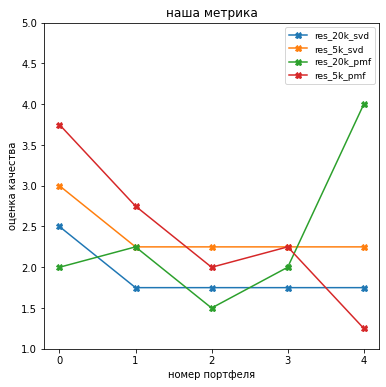

In [354]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(nrows=1, ncols=1)
x1 = [str(i) for i in range(5)]
for r in res:
    q20k = []
    q5k = []
    """
    for i in res[r]:
        if r == 'res_20k_svd' or r == 'res_20k_pfm':
            q20k.append(res[r][i][4])
        else:
            q5k.append(res[r][i][4])
    #print(r, np.array(cosine_m).mean())
    if r == 'res_20k_svd' or r == 'res_20k_pfm':
        axes[0].plot(x1, q20k, label=r)
    else:
        axes[1].plot(x1, q5k, label=r)
    """
    for i in res[r]:
        q20k.append(res[r][i][4])
    axes.plot(x1, q20k, marker = 'X', label=r)
            
fig.set_figwidth(6)
fig.set_figheight(6)
axes.legend(fontsize=9)
axes.set(title="наша метрика", xlabel="номер портфеля", ylabel='оценка качества')
axes.set_ylim([1, 5])
"""
axes[0].legend(fontsize=9)
axes[1].legend(fontsize=9)
axes[1].set(title="оценка рекомендательного портфеля при 5000 записей", xlabel="номер портфеля", ylabel='оценка')
axes[0].set(title="оценка рекомендательного портфеля при 20000 записей", xlabel="номер портфеля", ylabel='оценка')
axes[0].set_ylim([1, 4])
axes[1].set_ylim([1, 4])
"""
plt.show()

res_20k_svd 0.9443045432638201
res_5k_svd 0.9439375487321555
res_20k_pmf 0.9309221873947962
res_5k_pmf 0.9427253692586584


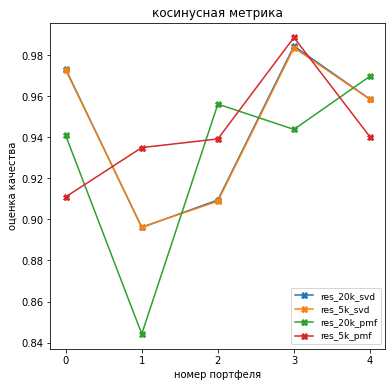

In [364]:
fig, axes = plt.subplots(nrows=1, ncols=1)
x1 = [str(i) for i in range(5)]
for r in res:
    cosine_m = []
    disp = []
    for i in res[r]:
        cosine_m.append(res[r][i][3])
        disp.append(res[r][i][2])
    print(r, np.array(cosine_m).mean())
    axes.plot(x1, cosine_m, marker = 'X', label=r)
    #axes[1].plot(x1, disp, label=r)

fig.set_figwidth(6)
fig.set_figheight(6)
axes.legend(fontsize=9)
#axes[1].legend(fontsize=9)
axes.set(title="косинусная метрика", xlabel="номер портфеля", ylabel='оценка качества')
plt.show()

Всем привет! Мы команда Волки с Озон стрит, хотим рассказать про свой проект Рекомендательная система портфеля акций.
Меня зовут Руслан, я начну рассказ с постановки задачи и исходных данных.
Имея в распоряжении матрицу рейтингов акций, мы хотим предложить инвесторам лучшие бумаги для улучшения качества портфеля. При этом учесть интересы инвестора, которые он выражает в своем запросе.

Основная гипотеза состоит в том, что имея в распоряжении размеченные портфели инвесторов с помощью методов вычислительной алгебры сможем выявить лучшие бумаги, которые торгуются на бирже.

Исходные данные были получены из открытых источников. Это данные о торгуемых бумагах на NYSE и NASDAQ. Данные о инвесторах получили путем тиражирования публичных портфелей крупных инвестиционных и консалтинговых компаний. Оценки формировались исходя из объемов открытых позиций инвесторами, т.е. чем больше инвестировано, тем выше оценка.
Получившаяся матрица содержит данные о 20 тысячах инвесторов и почти 6200 финансовых инстументов. Мартица разреженая, только 0.2% содержит не нули.

Давайте передем к методам, которые мы использовали для построения рекомендательной системы, слово передаю Лилии.

**Лиля рассказывает про КФ, СВД, ПМФ

При выборе метрики для оценки качества рекомендаций мы столкнулись с определенными проблемами, которые связаны с тем, что в идеале на каждую рекомендацию нам необходимо получить обратную связь от того для кого была эта рекомендация составлена. Но возможности провести такое исследоавние не представилось.
В итоге мы остановились на косинусной метрике. **Для каждой рекомендации находился угол расстояние до уже ранее купленных акций, и итоговая ошибка составляла среднее от ошибок всех рекомендаций. 

Но верить или нет этой метрике с точки зрения нашей прикладной задачи
вызывает сомнение.

В итоге мы решили еще добавить свою метрику, которая учитывает наиболее значимые финансовые/рисковые показатели для инвестора.

Кратко о нашей метрике. В нашу метрику для оценки включили 5 параметров (макс оценка для каждой рекомендации 5 баллов):
1. Диверсификация портфеля в зависимости от запроса инвестора.
2. EBITDA (прибыль до вычета расходов по выплате процентов, налогов, износа и начисленной амортизации).
3. Дивидендная доходность.
4. PERatio (отношение текущей рыночной цены за акцию компании к прибыли на одну акцию).
5. Волатильность (изменение цены бумаги за последние 52 недели).

**На слайд добавить подробное описание, голосом проговорить только по пункта

Как работает рекомендательная система?
На вход подается 5 акций - запрос инвестора, на "что он ориентируется". На выходе он получает рекомендацию - 5 акций, на которые стоит обратить внимание.

В результаты, представленые на слайде выносим 4 испытания (2 метода и две выборки) для 5 запросов инвесторов по разному профилю. 

Косинусная метрика показывает сопоставимые значения для всех методов и количества оценок портфелей инвесторами.
Лучше проявляет себя результат у выборки в 5000 записей и метод PMF.
Если посчитать средние значения, то SVD выигрывает на десятые доли процентов.
Однако, если посмотреть на рекомендации через призму практического применения, то очевидно, что на все запросы при использовании SVD мы получим одинаковый ответ и вряд ли это устроит пользователей. Но и в косинусной метрике для PMF не возможно понять на сколько интересны предлагаемые бумаги.

В нашей метрике получился такой результат. Метод PMF дает более качественные рекомендации. Однако есть "сложные" запросы от инвестора, по которым видимо не хватает оценок и тогда может выиграть SVD, который "ориентируется" на финансовые показатели компаний.
Также на портфеле №4 можно заметить, что на выборке в 20000 мы получили лучшую рекомендацию, а на выборке в 5000 худшую. Для исправления ситуации полагаем, что внутри PMF необходимо менять регуляризацию, которая лучше бы справлялась с исходными данными.

**надо сделать один слайд с разбором

Для примера давайте кратко разберем лучшую и худшую рекомендацию, чтобы показать как работает наша метрика.

**Если время будет поджимать, то эту часть можно сократить

Инвестор запрашивает рекомендацию похожую на 'GOOD', 'CWK', 'PTAC', 'VSAT', 'ATNI', получает резульат.
Для 5000: 'GPRO', 'SONO', 'HEAR', 'IRBT', 'LPL'
Для 20000: 'JNJ', 'LLY', 'VIOT', 'AMKR', 'KO'

**Выводы

Удалось разработать рекомендательную систему для портфеля акций с использованием методов вычислительной алгебры.
При получении запроса от инвесторов мы можем давать достаточно адекватные советы о потенциальных бумагах для включения в портфель.
Из применяемых методов лучшие результаты в нашей системе показывает метод PMF.

К перспективам развития проекта можно отнести:
Исследовать качество применения иных методов (например, тензорное разложение) для построения системы рекомендаций.
Усовершенствовать метрику оценки качества рекомендаций, исходя из обратной связи от пользователей системы.
